<a href="https://colab.research.google.com/github/GerardAlba/UdAAnaliticaFinancera/blob/main/UdAInsuranceClaimFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model de detecció del frau en sinistres de pòlisses assegurances

In [25]:
# Requeriments de versions
!pip install pandas==1.5.3

In [26]:
# Obtenim el dataset del fitxer csv al repositori públic del curs
import pandas as pd

#datapath = "insurance_claims.csv". Si csv ja el tenim a fitxers de l'entorn Colab

datapath ="https://raw.githubusercontent.com/GerardAlba/UdAAnaliticaFinancera/main/insurance_claims.csv"

data = pd.read_csv(datapath)

original_data = data.copy()

data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [27]:
# Descripció i Explorem dataset (EDA)

data.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', '_c39'],
      dtype='object')

In [28]:
data.shape

(1000, 40)

In [29]:
# Valors nulls
print("Null Values: " + str(data.isnull().any().sum()))

Null Values: 1


<Axes: xlabel='fraud_reported'>

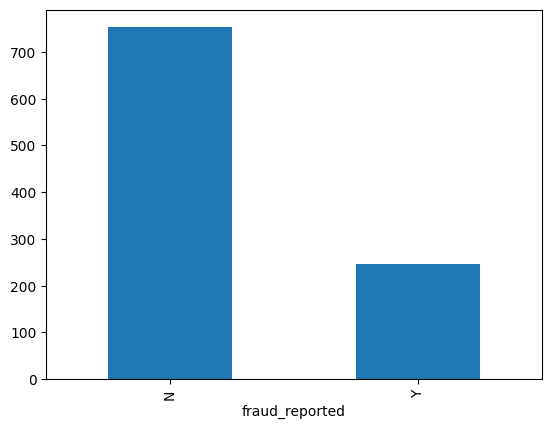

In [30]:
# Stats fraus reportats
df_count_fraud = data.groupby(['fraud_reported']).count()
df_fraud = df_count_fraud['policy_number']
df_fraud.plot.bar(x='Fraud Reported', y='Count')

<ipython-input-31-a852a9fedf65>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg_prem = data.groupby(['insured_education_level', 'fraud_reported']).mean()['policy_annual_premium']


<Axes: xlabel='insured_education_level'>

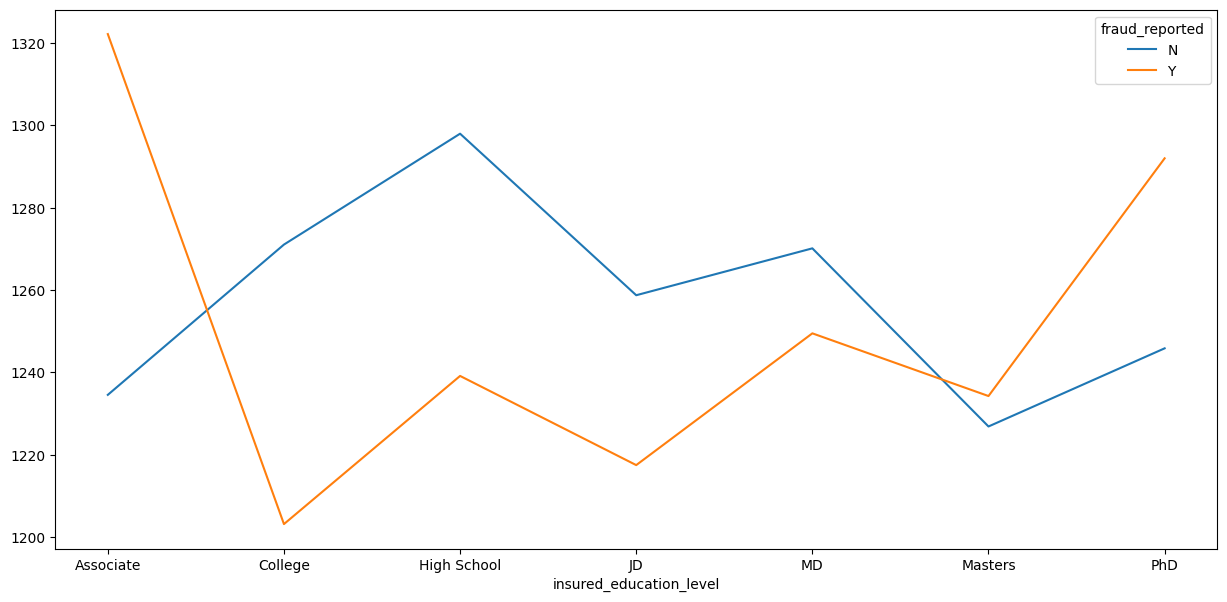

In [31]:
# Volum de primes anual per característica (ex: insured_education_level)
import matplotlib.pyplot as plt

# Grafiquem dades - compte versió pandas==1.5.3
fig, ax = plt.subplots(figsize=(15,7))
df_avg_prem = data.groupby(['insured_education_level', 'fraud_reported']).mean()['policy_annual_premium']
df_avg_prem.unstack().plot(ax=ax)

<ipython-input-32-e68a601522a5>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(['insured_occupation', 'fraud_reported']).mean()['total_claim_amount'].unstack().plot(ax=ax)


<Axes: xlabel='insured_occupation'>

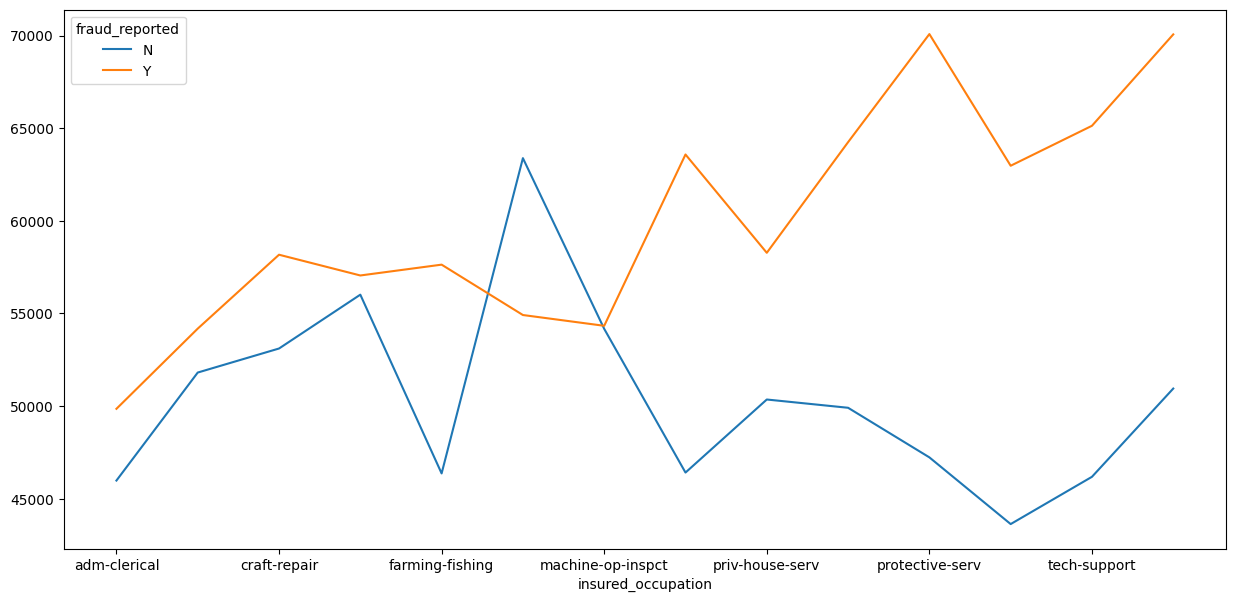

In [32]:
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['insured_occupation', 'fraud_reported']).mean()['total_claim_amount'].unstack().plot(ax=ax)

#### Grafiquem correlacions de les característiques (vars independets)

<ipython-input-33-9c49ea8e45c0>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


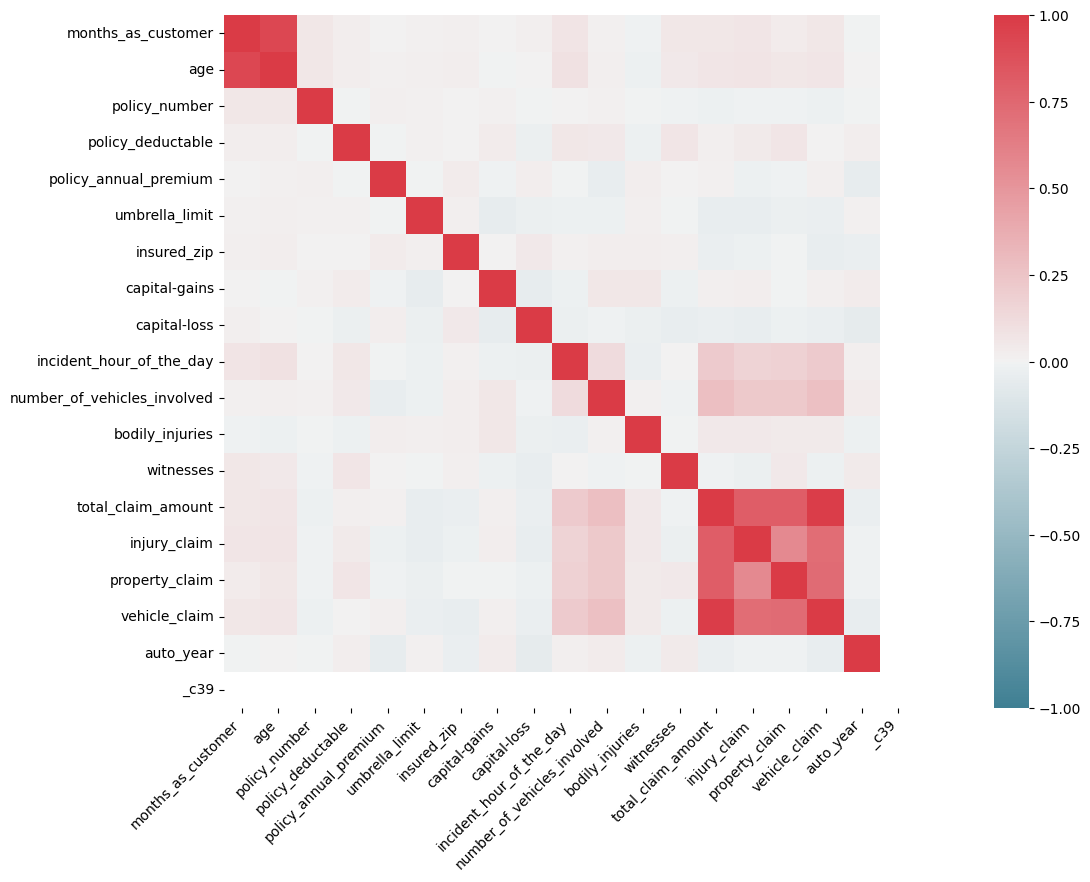

In [33]:
import numpy as np
import seaborn as sns

plt.figure(figsize=(20, 9))

corr = data.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [34]:
# No utilitzarem les columnes mens correlacionades amb frau
deleteCols = ["policy_number", "policy_bind_date", "insured_zip", "incident_location", "incident_date", "_c39"]
data = data.drop(deleteCols, axis=1)

In [35]:
#Handle Categorical Data
data.dtypes

,0
months_as_customer,int64
age,int64
policy_state,object
policy_csl,object
policy_deductable,int64
policy_annual_premium,float64
umbrella_limit,int64
insured_sex,object
insured_education_level,object
insured_occupation,object


#### Tractament dades no-numèriques. Label Encoder i OneHotEncoder
Label Encoder l'usarem per transformar no-numèric a numèric i OneHotEncoder per donar número a característica amb categories


In [36]:
#One-hot encoding all categorical columns except output column(i.e. fraud_reported)
list_hot_encoded = []
for column in data.columns:
    if(data[column].dtypes==object and column != 'fraud_reported'):
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        list_hot_encoded.append(column)
#Drop hot-encoded columns
data = data.drop(list_hot_encoded, axis=1)

#Binary encoder for output column
data['fraud_reported'] = data['fraud_reported'].map( {'Y':1, 'N':0})

data

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,328,48,1000,1406.91,0,53300,0,5,1,1,...,0,0,0,0,0,0,0,0,0,0
1,228,42,2000,1197.22,5000000,0,0,8,1,0,...,0,0,0,0,0,0,0,0,0,0
2,134,29,2000,1413.14,5000000,35100,0,7,3,2,...,0,1,0,0,0,0,0,0,0,0
3,256,41,2000,1415.74,6000000,48900,-62400,5,1,1,...,0,0,0,0,0,1,0,0,0,0
4,228,44,1000,1583.91,6000000,66000,-46000,20,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,1000,1310.80,0,0,0,20,1,0,...,0,0,0,0,0,0,0,0,0,0
996,285,41,1000,1436.79,0,70900,0,23,1,2,...,0,0,0,0,0,0,0,0,0,0
997,130,34,500,1383.49,3000000,35100,0,4,3,2,...,0,0,0,0,0,0,0,0,0,0
998,458,62,2000,1356.92,5000000,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0


###### Dades balancejades o no?
> Les dades de frau no són balancejades. Problema habitual, la majoria de sinistres no són frau. Això pot provocar que els models no facin èmfasi en frau, poques senyals de frau

<Axes: xlabel='fraud_reported', ylabel='count'>

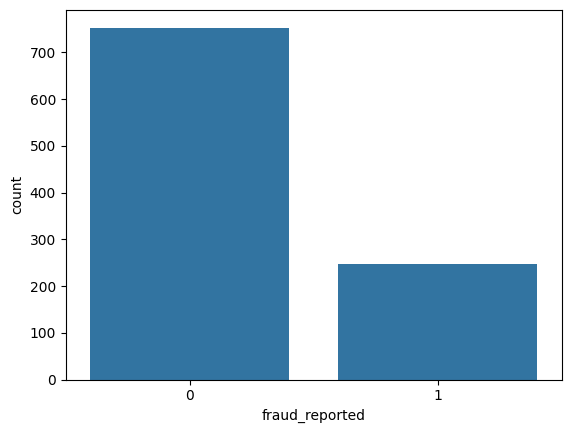

In [37]:
sns.countplot(x='fraud_reported',data=data)

## Entrenem els algorismes (Aprenentatge automàtic Supervisat per Classificar)

Evaluem precisió i mètriques ROC-AUC

In [38]:
# Model Train
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

y = data['fraud_reported']
X = data.drop(['fraud_reported'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### k-NN

In [39]:
from sklearn import neighbors

#K-Nearest Neighbors
print("KNN Score :")
KNNClassifier = neighbors.KNeighborsClassifier(n_neighbors=12, weights='distance')
KNNClassifier.fit(X=X_train,y=y_train)
KNNClassifier.score(X_test,y_test)

KNN Score :


0.7333333333333333

In [40]:
KNN_y_predicted = KNNClassifier.predict(X_test)
class_names = np.unique(np.array(y_test))
confusion_matrix(y_test, KNN_y_predicted)

array([[108,   5],
       [ 35,   2]])

In [41]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

print(classification_report(y_test, KNN_y_predicted))

scores = cross_val_score(KNNClassifier, X, y, cv=10, scoring='accuracy')
knn_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % knn_accuracy)

              precision    recall  f1-score   support

           0       0.76      0.96      0.84       113
           1       0.29      0.05      0.09        37

    accuracy                           0.73       150
   macro avg       0.52      0.50      0.47       150
weighted avg       0.64      0.73      0.66       150

Cross-Validated Accuracy: 0.73


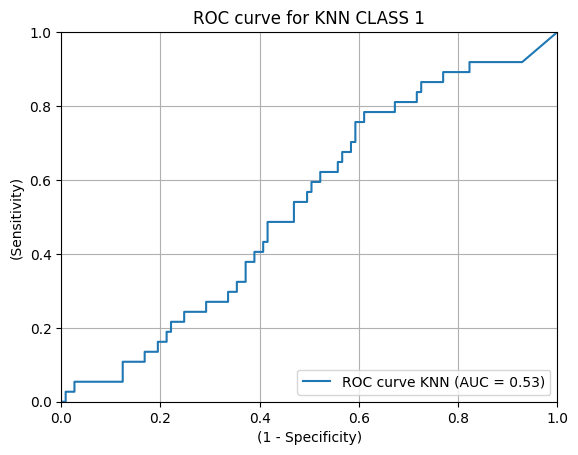

In [42]:
from sklearn.metrics import roc_curve, auc
knn_pred_prob = KNNClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, knn_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve KNN (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for KNN CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Arbre de Decisió (Decision Tree)

In [43]:
from sklearn import tree

#DecisionTree
DTClassifier = tree.DecisionTreeClassifier()
DTClassifier.fit(X_train, y_train)

print("Decision Tree Score :")
DTClassifier.score(X_test,y_test)

Decision Tree Score :


0.7733333333333333

In [44]:
DT_y_predicted = DTClassifier.predict(X_test)
class_names = np.unique(np.array(y_test))
confusion_matrix(y_test, DT_y_predicted)

array([[94, 19],
       [15, 22]])

In [45]:
print(classification_report(y_test, DT_y_predicted))

scores = cross_val_score(DTClassifier, X, y, cv=10, scoring='accuracy')
dt_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % dt_accuracy)

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       113
           1       0.54      0.59      0.56        37

    accuracy                           0.77       150
   macro avg       0.70      0.71      0.71       150
weighted avg       0.78      0.77      0.78       150

Cross-Validated Accuracy: 0.78


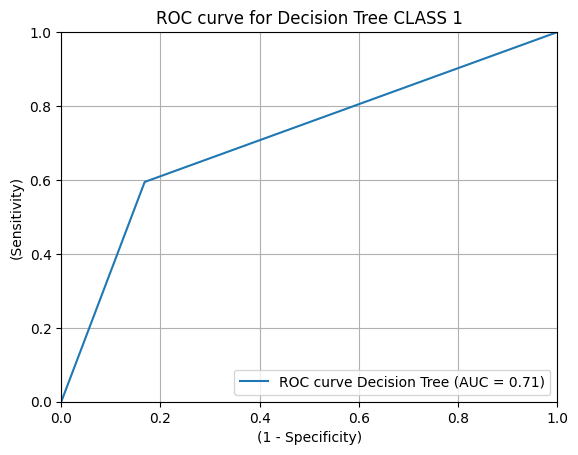

In [46]:
from sklearn.metrics import roc_curve, auc
dt_pred_prob = DTClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, dt_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve Decision Tree (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for Decision Tree CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Màquines de Vectors de Suport (SVM/SC)

In [47]:
from sklearn.svm import SVC

#Support Vector Machine
SVMClassifier = SVC(kernel='rbf',probability=True,random_state=42, gamma='auto')
SVMClassifier.fit(X_train, y_train)
print("SVM Score :")
SVMClassifier.score(X_test,y_test)

SVM Score :


0.7533333333333333

In [48]:
SVM_y_predicted = SVMClassifier.predict(X_test)
class_names = np.unique(np.array(y_test))
confusion_matrix(y_test, SVM_y_predicted)

array([[113,   0],
       [ 37,   0]])

In [49]:
from sklearn.metrics import classification_report
report = classification_report(y_test, SVM_y_predicted)
print(report)

scores = cross_val_score(SVMClassifier, X, y, cv=10, scoring='accuracy')
svm_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % svm_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86       113
           1       0.00      0.00      0.00        37

    accuracy                           0.75       150
   macro avg       0.38      0.50      0.43       150
weighted avg       0.57      0.75      0.65       150

Cross-Validated Accuracy: 0.75


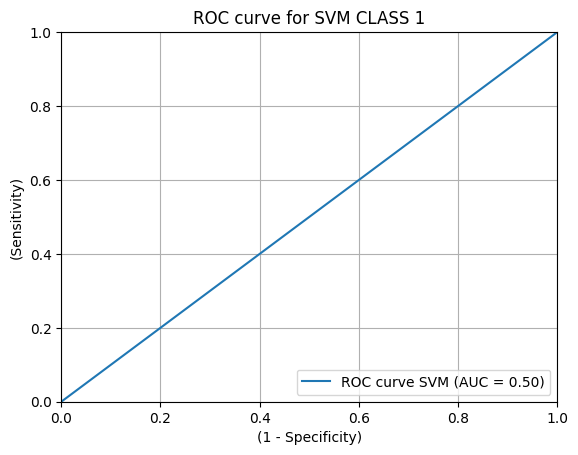

In [50]:
svm_pred_prob = SVMClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, svm_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve SVM (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for SVM CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Arbres Aleatoris (RandomForest)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#Random Forest
RFClassifier = RandomForestClassifier()
RFClassifier.fit(X_train, y_train)
print("Random Forest Score :")
RFClassifier.score(X_test,y_test)

Random Forest Score :


0.7133333333333334

In [52]:
RF_y_predicted = RFClassifier.predict(X_test)
class_names = np.unique(np.array(y_test))
confusion_matrix(y_test, RF_y_predicted)

array([[99, 14],
       [29,  8]])

In [53]:
from sklearn.metrics import classification_report
report = classification_report(y_test, RF_y_predicted)
print(report)

scores = cross_val_score(RFClassifier, X, y, cv=10, scoring='accuracy')
rf_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % rf_accuracy)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       113
           1       0.36      0.22      0.27        37

    accuracy                           0.71       150
   macro avg       0.57      0.55      0.55       150
weighted avg       0.67      0.71      0.69       150

Cross-Validated Accuracy: 0.77


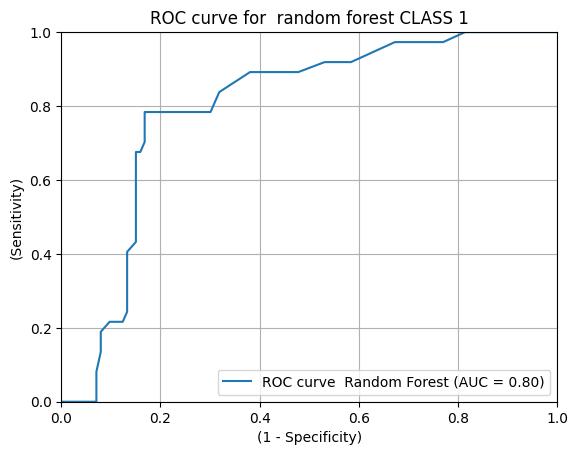

In [54]:
from sklearn.metrics import roc_curve, auc
rf_pred_prob = RFClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve  Random Forest (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for  random forest CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [55]:
from imblearn.ensemble import BalancedRandomForestClassifier
#Balanced Random Forest
BRFClassifier=BalancedRandomForestClassifier()
BRFClassifier.fit(X_train, y_train)
print("Balanced Random Forest Score :")
BRFClassifier.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Balanced Random Forest Score :


0.8

In [56]:
BRF_y_predicted = BRFClassifier.predict(X_test)
report = classification_report(y_test, BRF_y_predicted)
print(report)

scores = cross_val_score(BRFClassifier, X, y, cv=10, scoring='accuracy')
brf_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % brf_accuracy)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       113
           1       0.58      0.70      0.63        37

    accuracy                           0.80       150
   macro avg       0.74      0.77      0.75       150
weighted avg       0.82      0.80      0.81       150



/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.

Cross-Validated Accuracy: 0.83


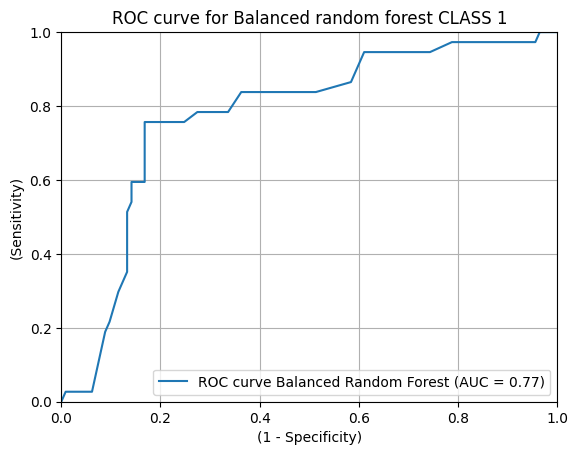

In [57]:
brf_pred_prob = BRFClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, brf_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve Balanced Random Forest (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for Balanced random forest CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Anàlisi discriminant lineal (LDA)

In [58]:
#LDA model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(X_train, y_train)
print("Linear Discriminant Analysis Score :")
lda.score(X_test,y_test)

Linear Discriminant Analysis Score :


0.8266666666666667

In [59]:
lda_y_predicted = lda.predict(X_test)
report = classification_report(y_test, lda_y_predicted)
print(report)

scores = cross_val_score(lda, X, y, cv=10, scoring='accuracy')
lda_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % lda_accuracy)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       113
           1       0.66      0.62      0.64        37

    accuracy                           0.83       150
   macro avg       0.77      0.76      0.76       150
weighted avg       0.82      0.83      0.83       150

Cross-Validated Accuracy: 0.84


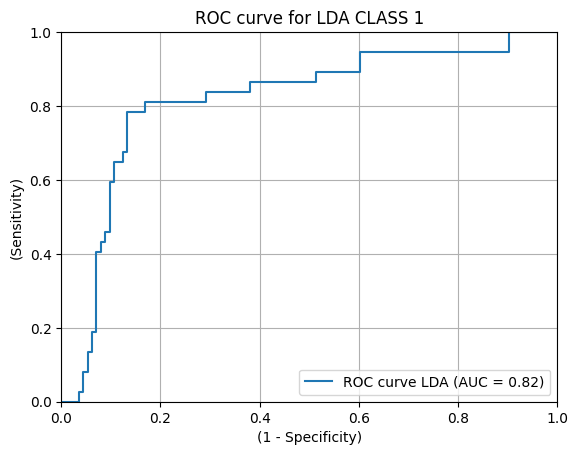

In [60]:
lda_pred_prob = lda.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lda_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve LDA (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for LDA CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Naïve Bayes Bernoulli

In [61]:
from sklearn.naive_bayes import BernoulliNB
#Naive Bayes Classifier
NBClassifier = BernoulliNB()
NBClassifier.fit(X_train, y_train)
print("Naive Bayes Classifier Score :")
NBClassifier.score(X_test,y_test)

Naive Bayes Classifier Score :


0.8

In [62]:
nb_y_predicted = NBClassifier.predict(X_test)
report = classification_report(y_test, nb_y_predicted)

print(report)

scores = cross_val_score(NBClassifier, X, y, cv=10, scoring='accuracy')
nb_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % nb_accuracy)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       113
           1       0.59      0.62      0.61        37

    accuracy                           0.80       150
   macro avg       0.73      0.74      0.74       150
weighted avg       0.80      0.80      0.80       150

Cross-Validated Accuracy: 0.82


### XGBoost

In [63]:
from xgboost import XGBClassifier
#XGBOOST Classifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train, verbose=False)
print("XGBClassifier Score :")
model_xgb.score(X_test,y_test)

XGBClassifier Score :


0.76

In [64]:
xgboost_y_predicted = model_xgb.predict(X_test)
report = classification_report(y_test, xgboost_y_predicted)

print(report)

scores = cross_val_score(model_xgb, X, y, cv=10, scoring='accuracy')
xgb_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % xgb_accuracy)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       113
           1       0.52      0.46      0.49        37

    accuracy                           0.76       150
   macro avg       0.67      0.66      0.66       150
weighted avg       0.75      0.76      0.76       150

Cross-Validated Accuracy: 0.81


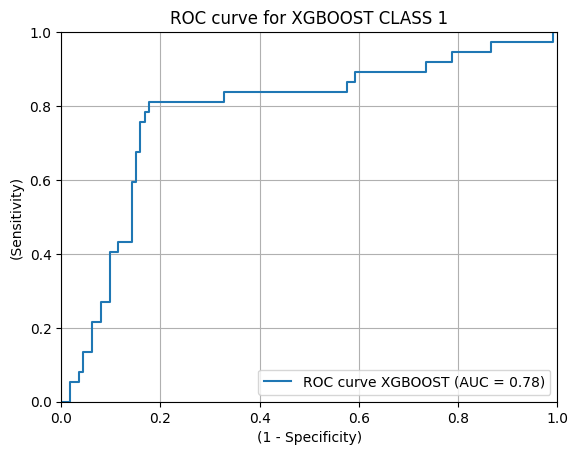

In [65]:
xgb_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve XGBOOST (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for XGBOOST CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Xarxa Neuronal: Multilayer Perceptron Classifier

In [66]:
from sklearn.neural_network import MLPClassifier
#Newral Network Classifier
clf_MLP = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64))
clf_MLP.fit(X_train, y_train)
print("MLPClassifier Score :")
clf_MLP.score(X_test,y_test)

MLPClassifier Score :


0.6733333333333333

In [67]:
mlp_y_predicted = clf_MLP.predict(X_test)
report = classification_report(y_test, mlp_y_predicted)

print(report)

scores = cross_val_score(clf_MLP, X, y, cv=10, scoring='accuracy')
mlp_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % mlp_accuracy)

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       113
           1       0.17      0.08      0.11        37

    accuracy                           0.67       150
   macro avg       0.45      0.47      0.45       150
weighted avg       0.60      0.67      0.63       150

Cross-Validated Accuracy: 0.66


### Comparativa dels models

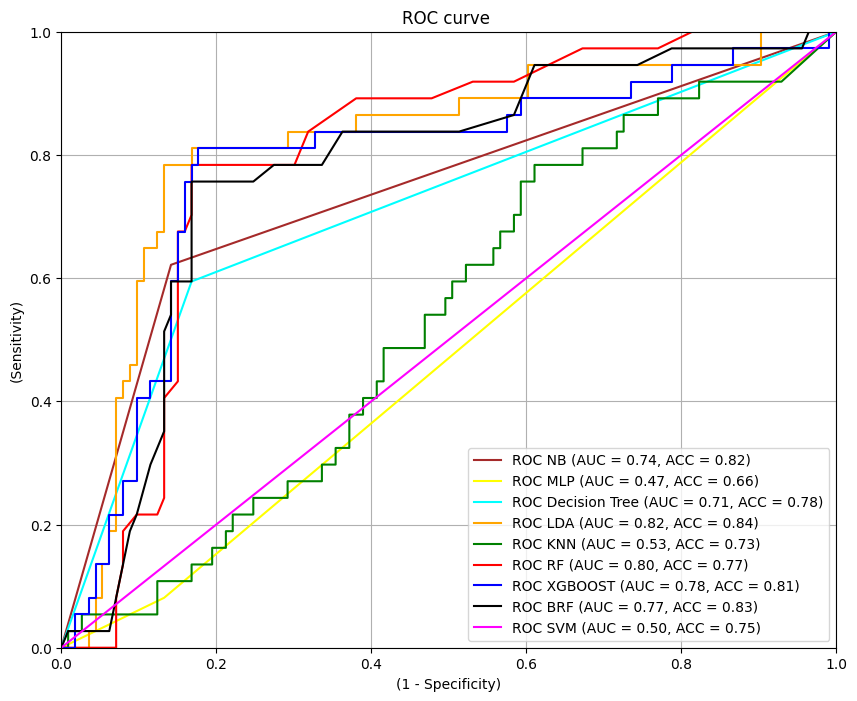

The predictive power of each model expressed by ROC curves. For instance, Linear Discriminant Analysis and XGBOOST model has        higher probability of accurate prediction of correct class member, and gaining high level of accuracy prediction probability        as compared to Random Forest, KNN, Naive Bayes, Neural Network and SVM models.


In [68]:
fpr9, tpr9, thresholds9 = roc_curve(y_test, nb_y_predicted)
roc_auc9 = auc(fpr9, tpr9)

fpr8, tpr8, thresholds8 = roc_curve(y_test, mlp_y_predicted)
roc_auc8 = auc(fpr8, tpr8)

fpr7, tpr7, thresholds7 = roc_curve(y_test, DT_y_predicted)
roc_auc7 = auc(fpr7, tpr7)

fpr6, tpr6, thresholds6 = roc_curve(y_test, lda_pred_prob)
roc_auc6 = auc(fpr6, tpr6)

fpr5, tpr5, thresholds5 = roc_curve(y_test, knn_pred_prob)
roc_auc5 = auc(fpr5, tpr5)

fpr4, tpr4, thresholds4 = roc_curve(y_test, rf_pred_prob)
roc_auc4 = auc(fpr4, tpr4)

fpr3, tpr3, thresholds3 = roc_curve(y_test, xgb_pred_prob)
roc_auc3 = auc(fpr3, tpr3)

fpr2, tpr2, thresholds2 = roc_curve(y_test, brf_pred_prob)
roc_auc2 = auc(fpr2, tpr2)

fpr1, tpr1, thresholds1 = roc_curve(y_test,svm_pred_prob)
roc_auc1 = auc(fpr1, tpr1)
lw = 2
plt.figure(figsize=(10, 8))
plt.plot(fpr9, tpr9,color='brown',label='ROC NB (AUC = %0.2f, ACC = %0.2f)' % (roc_auc9, nb_accuracy))
plt.plot(fpr8, tpr8,color='yellow',label='ROC MLP (AUC = %0.2f, ACC = %0.2f)' % (roc_auc8, mlp_accuracy))
plt.plot(fpr7, tpr7,color='cyan',label='ROC Decision Tree (AUC = %0.2f, ACC = %0.2f)' % (roc_auc7, dt_accuracy))
plt.plot(fpr6, tpr6,color='orange',label='ROC LDA (AUC = %0.2f, ACC = %0.2f)' % (roc_auc6, lda_accuracy))
plt.plot(fpr5, tpr5,color='green',label='ROC KNN (AUC = %0.2f, ACC = %0.2f)' % (roc_auc5, knn_accuracy))
plt.plot(fpr4, tpr4,color='red',label='ROC RF (AUC = %0.2f, ACC = %0.2f)' % (roc_auc4, rf_accuracy))
plt.plot(fpr3, tpr3,color='blue',label='ROC XGBOOST (AUC = %0.2f, ACC = %0.2f)' % (roc_auc3, xgb_accuracy))
plt.plot(fpr2, tpr2,color='black',label='ROC BRF (AUC = %0.2f, ACC = %0.2f)' % (roc_auc2, brf_accuracy))
plt.plot(fpr1, tpr1,color='magenta',label='ROC SVM (AUC = %0.2f, ACC = %0.2f)' % (roc_auc1, svm_accuracy))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve ')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

print("The predictive power of each model expressed by ROC curves. For instance, Linear Discriminant Analysis and XGBOOST model has\
        higher probability of accurate prediction of correct class member, and gaining high level of accuracy prediction probability\
        as compared to Random Forest, KNN, Naive Bayes, Neural Network and SVM models.")

### Importància de les característiques
Ho fem amb XGBoost, model que hem vist té millor performance

In [69]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'feature':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi):
    return fi.plot('feature', 'imp', 'barh', figsize=(15,7), legend=False)

fi = rf_feat_importance(model_xgb, X_train); fi[:15]

,feature,imp
79,incident_severity_Major Damage,0.087458
50,insured_hobbies_chess,0.060024
51,insured_hobbies_cross-fit,0.049644
149,auto_model_Neon,0.038847
151,auto_model_Pathfinder,0.030619
39,insured_occupation_priv-house-serv,0.029176
142,auto_model_Jetta,0.028615
97,incident_city_Hillsdale,0.019856
98,incident_city_Northbend,0.018978
42,insured_occupation_sales,0.016345


<Axes: ylabel='feature'>

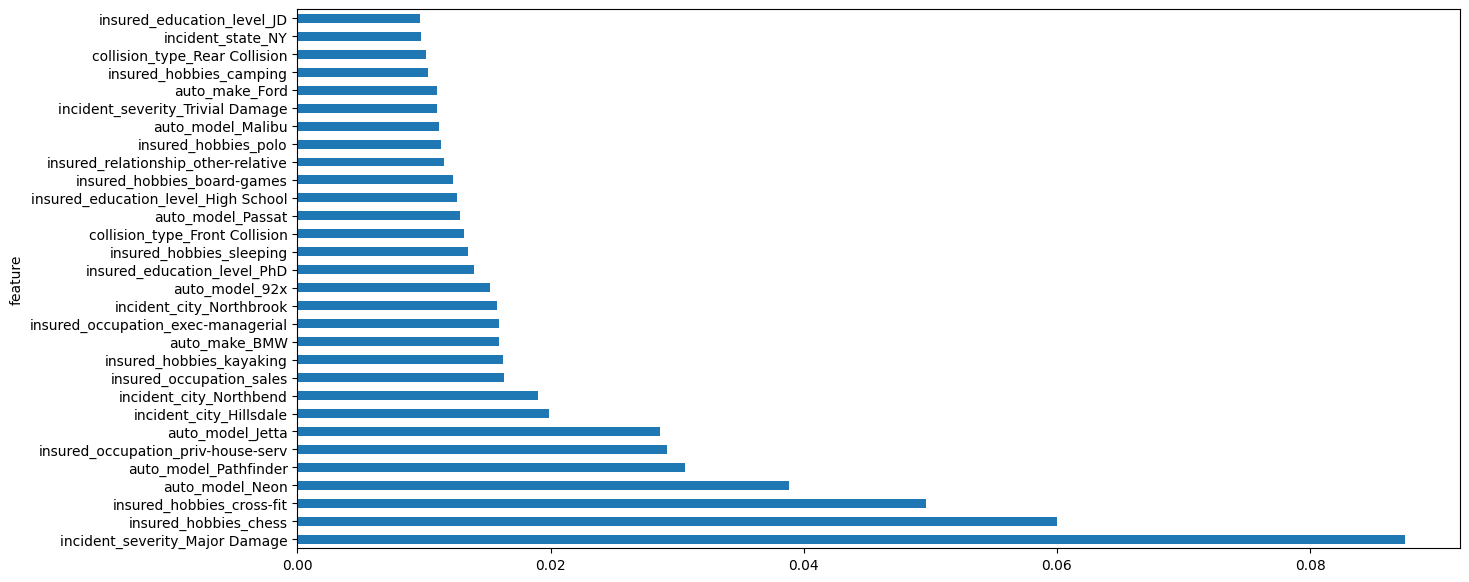

In [70]:
plot_fi(fi[:30])

## Scoring i Ranking

Usem XGBoost que mostra millor comportament

In [71]:
test_target = y_test.copy()
test_target.reset_index(drop=True, inplace=True)
test_target = test_target.replace({1:'Y', 0:'N'})

predicted_target = model_xgb.predict(X_test)
predicted_target = pd.Series(predicted_target).replace({1:'Y', 0:'N'})

In [72]:
ranks=pd.DataFrame(data=
                   {
                       'RealClass':test_target,
                       'PredictedClass':predicted_target,
                       'rank':xgb_pred_prob
                   })
ranks.sort_values(by=['rank'],ascending=False,inplace=True)
ranks.head()

,RealClass,PredictedClass,rank
34,N,Y,0.996424
149,N,Y,0.978848
7,Y,Y,0.976585
127,Y,Y,0.975345
82,N,Y,0.963762


In [73]:
top = ranks.where(ranks['rank']>0.5,).dropna()
top.head()

,RealClass,PredictedClass,rank
34,N,Y,0.996424
149,N,Y,0.978848
7,Y,Y,0.976585
127,Y,Y,0.975345
82,N,Y,0.963762
